In [1]:
import os 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
#from load_data import *
from itertools import chain
from collections import Counter
import re
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Extract labeled data

In [ ]:
device_path = "/Volumes/TOSHIBA EXT/images"
images_path = os.listdir("/Volumes/TOSHIBA EXT/images")
images_path.sort()

In [4]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
prefix = "https://airbnb.de"
suffix = "/photos"
urls = listings["listing_url"]
ids = listings["id"]

In [5]:
images_path = pd.Series(images_path)
listing_ids = images_path.str.extract("(^\d*)").values

NameError: ignored

In [6]:
data = open("labels_raw.json")
labels_raw = json.load(data)

FileNotFoundError: ignored

## Get an overview over the most common words

In [ ]:
ids = list(labels_raw.keys())
all_labels_raw = []
for i in ids:
    all_labels_raw += labels_raw[i]
words_raw = pd.Series(all_labels_raw).str.lower().str.split()
all_words_raw = list(chain.from_iterable(list(words_raw.values)))
c = Counter(all_words_raw)
c.most_common(50)


[('image', 55910),
 ('listing', 53514),
 ('the', 5824),
 ('2', 5523),
 ('1', 5515),
 ('bedroom', 5203),
 ('room', 4962),
 ('3', 4830),
 ('4', 4273),
 ('5', 4050),
 ('and', 3992),
 ('6', 3613),
 ('with', 3573),
 ('kitchen', 3246),
 ('7', 3225),
 ('living', 3117),
 ('8', 2918),
 ('bathroom', 2865),
 ('9', 2626),
 ('10', 2510),
 ('of', 2351),
 ('to', 2222),
 ('a', 2126),
 ('11', 2122),
 ('12', 1888),
 ('in', 1792),
 ('13', 1674),
 ('area', 1658),
 ('from', 1649),
 ('14', 1500),
 ('15', 1420),
 ('double', 1366),
 ('view', 1365),
 ('bed', 1349),
 ('is', 1289),
 ('16', 1199),
 ('dining', 1199),
 ('for', 1163),
 ('-', 1120),
 ('garden', 1110),
 ('17', 1101),
 ('18', 1033),
 ('19', 957),
 ('20', 922),
 ('shower', 858),
 ('full', 809),
 ('21', 777),
 ('on', 777),
 ('front', 749),
 ('main', 728)]

We can use the keywords bedroom, bed, living, bathroom, kitchen, garden and dining to extract pictures containing these types of rooms. 
Therefore we construct a loop over all listings which searches for one of the words in the raw labels and loads the corresponding image, saving it with the listing id and its category.

In [ ]:
images = []
labels = []
listing_ids = []

for id in tqdm(ids):
    sample = labels_raw[id]

    bedrooms = []
    bathrooms = []
    living_rooms = []
    kitchen = []
    dining = []
    garden = []

    for i in sample:
        regex = re.compile("(^bed| bed |bed$|bedroom)")
        bedrooms.append(bool(re.search(regex, i)))

        regex = re.compile("(^bath| bath)")
        bathrooms.append(bool(re.search(regex, i)))

        regex = re.compile("(living room|livingroom)")
        living_rooms.append(bool(re.search(regex, i)))

        regex = re.compile("kitchen")
        kitchen.append(bool(re.search(regex, i)))

        regex = re.compile("(dining room|diningroom|dining area|dining hall)")
        dining.append(bool(re.search(regex, i)))

        regex = re.compile("(garden)")
        garden.append(bool(re.search(regex, i)))


    bedrooms = np.where(np.array(bedrooms))[0]
    bathrooms = np.where(np.array(bathrooms))[0]
    living_rooms = np.where(np.array(living_rooms))[0]
    kitchen = np.where(np.array(kitchen))[0]
    dining = np.where(np.array(dining))[0]
    garden = np.where(np.array(garden))[0]

    for i in bedrooms:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("bedroom")
        listing_ids.append(id)

    for i in bathrooms:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("bathrooms")
        listing_ids.append(id)

    for i in living_rooms:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("living_rooms")
        listing_ids.append(id)

    for i in kitchen:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("kitchen")
        listing_ids.append(id)

    for i in dining:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("dining")
        listing_ids.append(id)

    for i in garden:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("garden")
        listing_ids.append(id)

100%|██████████| 6976/6976 [01:30<00:00, 77.05it/s] 


In [ ]:
np.array(images).shape

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_6587/3287615203.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(images).shape


(7056,)

bedroom 44077


/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_6587/1374171950.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j, i in enumerate(np.array(images)[np.array(labels) == "garden"][:30]):


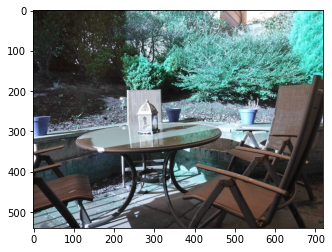

bedroom 44077


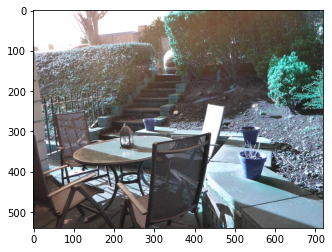

In [ ]:
for j, i in enumerate(np.array(images)[np.array(labels) == "garden"][:30]):
    print(labels[j], listing_ids[j])
    plt.imshow(i)
    plt.show()


In [ ]:
import matplotlib.image
import cv2

bedroom 85156


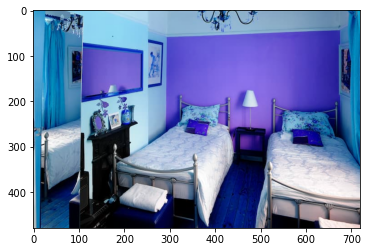

bedroom 85156


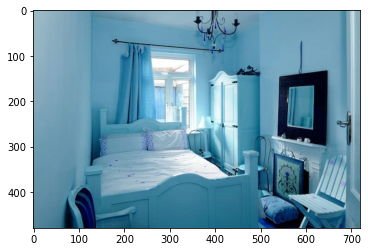

garden 85156


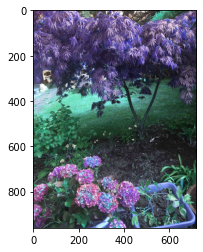

In [ ]:
id = "85156"
sample = labels_raw[id]

num_pictures = len(sample)

bedrooms = []
bathrooms = []
living_rooms = []
kitchen = []
dining = []
garden = []

images = []
labels = []
listing_ids = []

for i in sample:
    regex = re.compile("(^bed| bed |bed$|bedroom)")
    bedrooms.append(bool(re.search(regex, i)))

    regex = re.compile("(^bath| bath)")
    bathrooms.append(bool(re.search(regex, i)))

    regex = re.compile("(living room|livingroom)")
    living_rooms.append(bool(re.search(regex, i)))

    regex = re.compile("kitchen")
    kitchen.append(bool(re.search(regex, i)))

    regex = re.compile("(dining room|diningroom|dining area|dining hall)")
    dining.append(bool(re.search(regex, i)))

    regex = re.compile("(garden|outside area)")
    garden.append(bool(re.search(regex, i)))


bedrooms = np.where(np.array(bedrooms))[0]
bathrooms = np.where(np.array(bathrooms))[0]
living_rooms = np.where(np.array(living_rooms))[0]
kitchen = np.where(np.array(kitchen))[0]
dining = np.where(np.array(dining))[0]
garden = np.where(np.array(garden))[0]

for i in bedrooms:
    path = device_path + "/" + id+"_"+str(i)+".png"
    img = cv2.imread(path)
    images.append(img)
    labels.append("bedroom")
    listing_ids.append(id)

for i in bathrooms:
    path = device_path + "/" + id+"_"+str(i)+".png"
    img = cv2.imread(path)
    images.append(img)
    labels.append("bathrooms")
    listing_ids.append(id)

for i in living_rooms:
    path = device_path + "/" + id+"_"+str(i)+".png"
    img = cv2.imread(path)
    images.append(img)
    labels.append("living_rooms")
    listing_ids.append(id)

for i in kitchen:
    path = device_path + "/" + id+"_"+str(i)+".png"
    img = cv2.imread(path)
    images.append(img)
    labels.append("kitchen")
    listing_ids.append(id)

for i in dining:
    path = device_path + "/" + id+"_"+str(i)+".png"
    img = cv2.imread(path)
    images.append(img)
    labels.append("dining")
    listing_ids.append(id)

for i in garden:
    path = device_path + "/" + id+"_"+str(i)+".png"
    img = cv2.imread(path)
    images.append(img)
    labels.append("garden")
    listing_ids.append(id)


for j, i in enumerate(images):
    print(labels[j], listing_ids[j])
    plt.imshow(i)
    plt.show()


  

## Instead of labels extract only embeddings from resnet first

In [7]:
model = ResNet50(include_top=False, weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [20]:
path = "/content/drive/MyDrive/DubAir/44077_0.png"
img = image.load_img(path, target_size = (224, 224))


In [16]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis =0)

In [17]:
img_array = preprocess_input(img_array)

In [18]:
pred = model.predict(img_array)

In [19]:
pred.shape

(1, 15, 23, 2048)

In [3]:
!pip install -U image_embeddings

     |████████████████████████████████| 87 kB 3.8 MB/s 
     |████████████████████████████████| 7.0 MB 18.5 MB/s 
     |████████████████████████████████| 50 kB 3.8 MB/s 
  Created wheel for image-embeddings: filename=image_embeddings-1.4.0-py3-none-any.whl size=13137 sha256=8c1186f6755d78251154acb5cc7c8d41f6940dc552dd05f7b9be87d50d55a863
  Stored in directory: /root/.cache/pip/wheels/6a/62/71/a6168d1ce33726065932a43604da9198b7b2bcc018bc1cbcb9
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=988b190bc1f135639e17a634801d73f3966d8aa9b2088c733565313b2a1c4e38
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built image-embeddings fire


In [2]:
import image_embeddings
import pyarrow.parquet as pq
import cv2
import os
from google.colab.patches import cv2_imshow
from dataclasses import dataclass
from IPython.display import Image, display
from ipywidgets import widgets, HBox, VBox
import faiss
import numpy as np
import random
import json
from pathlib import Path


def display_picture(image_path, image_name):
    display(Image(filename=f"{image_path}/{image_name}.png"))

def display_picture(image_path, image_name):
    display(Image(filename=f"{image_path}/{image_name}.png"))


def display_results(image_path, results):
    hbox = HBox(
        [
            VBox(
                [
                    widgets.Label(f"{distance:.2f} {image_name}"),
                    widgets.Image(value=open(f"{image_path}/{image_name}.png", "rb").read()),
                ]
            )
            for distance, image_name in results
        ]
    )
    display(hbox)

In [46]:
resized_path = "/content/drive/MyDrive/DubAir/img_embeddings/tf_airbnb/images_resized/"

dir = os.listdir("/content/drive/MyDrive/DubAir/images")
dir = dir[:len(dir)-1]

img_names = pd.Series(dir).str.split(".").str[0].values

for img_dir, resized_img_dir in zip(dir, img_names):
  img_dir_tmp = "/content/drive/MyDrive/DubAir/images/"+ img_dir
  img_tmp = cv2.imread(img_dir_tmp)
  img_tmp = cv2.resize(img_tmp, dsize=(256, 256))
  path_tmp = resized_path + resized_img_dir + ".png"
  cv2.imwrite(path_tmp, img_tmp)


In [3]:
# Let's define some paths where to save images, tfrecords and embeddings
from pathlib import Path
home = str("/content/drive/MyDrive/DubAir/img_embeddings")
dataset = "tf_airbnb"
path_images = f"{home}/{dataset}/images_resized"
path_tfrecords = f"{home}/{dataset}/tfrecords"
path_embeddings = f"{home}/{dataset}/embeddings"

In [4]:
image_embeddings.inference.write_tfrecord(image_folder=path_images,
                                          output_folder=path_tfrecords,
                                          num_shards=10)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`
Shard 0 saved after 40s
Shard 1 saved after 44s
Shard 2 saved after 49s
Shard 3 saved after 53s
Shard 4 saved after 57s
Shard 5 saved after 62s
Shard 6 saved after 66s
Shard 7 saved after 70s
Shard 8 saved after 74s
Shard 9 saved after 79s


In [4]:
image_embeddings.inference.run_inference(tfrecords_folder=path_tfrecords,
                                         output_folder=path_embeddings,
                                         batch_size=100)

16/16 [==============================] - 99s 6s/step

Shard 0 done after 98s
Shard 0 saved after 102s
16/16 [==============================] - 96s 6s/step

Shard 1 done after 198s
Shard 1 saved after 202s
16/16 [==============================] - 94s 6s/step

Shard 2 done after 344s
Shard 2 saved after 347s
16/16 [==============================] - 94s 6s/step

Shard 3 done after 489s
Shard 3 saved after 493s
16/16 [==============================] - 105s 7s/step

Shard 4 done after 635s
Shard 4 saved after 639s
16/16 [==============================] - 97s 6s/step

Shard 5 done after 781s
Shard 5 saved after 785s
16/16 [==============================] - 100s 6s/step

Shard 6 done after 884s
Shard 6 saved after 888s
16/16 [==============================] - 104s 6s/step

Shard 7 done after 992s
Shard 7 saved after 995s
16/16 [==============================] - 113s 7s/step

Shard 8 done after 1137s
Shard 8 saved after 1141s
16/16 [==============================] - 109s 7s/step

Shard 9 done 

In [5]:
[id_to_name, name_to_id, embeddings] = image_embeddings.knn.read_embeddings(path_embeddings)
index = image_embeddings.knn.build_index(embeddings)

23691939_23


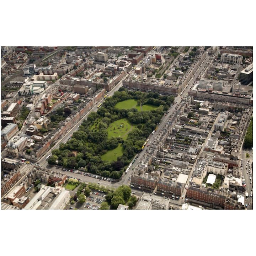

In [27]:
p=560
print(id_to_name[p])
display_picture(path_images, id_to_name[p])
results = image_embeddings.knn.search(index, id_to_name, embeddings[p], k = 20)
display_results(path_images, results)